---
title: "SMTMSMT: Gluing Together CVC5 and Z3 Nelson Oppen Style"
date: 
---

Satisfiability module theories solvers are a gluing together of domain specific theories with a SAT solver.

# Ignore SAT

While there is a conventional story where you explain SAT solvers first, and then how to extend them with theories, I think it's kind of interesting conceptual approach to take the starting point as the theory combination problem and totally ignore the SAT part. Half or more of an introductory talk is about how backtracking and CDCL kind of works. Our solver will only consider problems of the form `p /\ q /\ not r /\ ...`. This seems more relevant for the needs of a saturating solver like EMT anyhoo.

Let us just say we have a pile of solvers that accept only conjunctions of literals. How can we combine them?

# Externalizing Nelson Oppen out of Z3

An interesting illustration of this problem can be found by externalizing the theory combination problem out of Z3 and into the python layer.

If you make multiple `Solver` objects in z3, they do not communicate to each other. However, we are staying entirely inside of z3, so some things remain easier to translate between solvers than if the solvers were truly foreign

The basic steps are purification and then propagation. Purification separates statements into theory specific parts by flattening them using fresh symbols, and then dispatching them to the appropriate solver based on some criteria.

Here is a routine to flatten an expression

In [58]:
from collections import defaultdict
def flatten(t : smt.ExprRef):
    res = defaultdict(list)
    e = smt.FreshConst(t.sort(),prefix="e")
    todo = [(e,t)]
    consts = [e]
    while todo:
        e, t = todo.pop()
        f, args = t.decl(), t.children()
        xs = [smt.FreshConst(arg.sort(), prefix="e") for arg in args]
        consts.extend(xs)
        res[f].append(e == f(*xs))
        todo.extend(zip(xs, args))
    return e, res, consts

f = smt.Function("f", smt.IntSort(), smt.IntSort())
flatten(f(f(3)) + f(4))


(e!408,
 defaultdict(list,
             {+: [e!403 == e!404 + e!405],
              f: [e!405 == f(e!406), e!404 == f(e!407), e!407 == f(e!408)],
              Int: [4 == e!406],
              Int: [3 == e!408]}),
 [e!403, e!404, e!405, e!406, e!407, e!408])

Here I have two solver objects inside the combination solver. When you `add` a constraint, it flattens it and then dispatch based on the function symbol to the solver that should be responsible for that symbol.

The constants that possibly span theories are also tracked for the purposes of using them during propagation.

Propagation is a giant loop where we query each solver to determine if `ei = ej` or `ei != ej` are forced to be true. I do a slightly fancy thing where I shrink the set, but one could also do this one by one for the suggested propagation literals.


In [60]:
from dataclasses import dataclass
from kdrag.all import *

class NOSolver():
    def __init__(self):
        self.arith = smt.Solver()
        arith = self.arith
        self.euf = smt.Solver()
        self.theories = [arith, self.euf]
        self.consts = []
        x = smt.Real("x")
        self.decls = {
            (x + x).decl() : arith,
            (x - x).decl() : arith,
            smt.RealVal(2).decl() : arith, # cheating a little here
            smt.RealVal(0).decl() : arith,
            (x > x).decl() : arith
        }
    def add(self, lit : smt.BoolRef):
        children = []
        for arg in lit.children():
                e, fs, consts = flatten(arg)
                children.append(e)
                self.consts.extend(consts)
                for f, eqs in fs.items():
                    s = self.decls.get(f, self.euf)
                    s.add(eqs)
        if smt.is_eq(lit):
            for th in self.theories:
                th.add(children[0] == children[1])
        elif smt.is_distinct(lit):
            for th in self.theories:
                th.add([children[i] != children[j] for i in range(len(children)) for j in range(i)])
        else:
            decl = lit.decl()
            th = self.decls[decl]
            th.add(decl(*children))
    def propagate(self):
        known = set()
        props0 = [c == c1 for c in self.consts for c1 in self.consts if c.get_id() < c1.get_id()]
        props0.extend([c != c1 for c in self.consts for c1 in self.consts if c.get_id() < c1.get_id()])
        while True:
            curlen = len(known)
            for th in self.theories:
                if th.check() == smt.unsat:
                    return smt.unsat
                with th:
                    props = set(props0) - known
                    while True:
                        th.add(smt.Not(smt.And(props)))
                        res = th.check()
                        if res == smt.sat:
                            props = [p for p in props if smt.is_true(th.model().eval(p))]
                        else:
                            break
                if len(props) != 0:
                    print("Propagating", props)
                    known.update(props)
                for th in self.theories:
                        th.add(props)
            if len(known) == curlen:
                break
        return smt.unknown

    def check(self):
        return self.propagate()
        #for th in self.theories:
        #    if th.check() == smt.unsat:
        #        return smt.unsat
        #return smt.unknown
    def model(self):
        for th in self.theories:
            th.check()
        return [th.model() for th in self.theories]
            

a,x,y = smt.Reals("a x y")
f = smt.Function("f", smt.RealSort(), smt.RealSort())
s = NOSolver()
s.add(f(f(x) - f(y)) == a)
s.add(f(0) > a + 2)
s.add(x == y)
#s.check()
print("euf", s.euf)
print("arith", s.arith)
s.consts
s.propagate()
s.check()
s.model()

euf [e!423 == f(e!424),
 e!426 == f(e!427),
 e!425 == f(e!428),
 e!427 == y,
 e!428 == x,
 e!429 == a,
 e!428 == e!429,
 e!430 == f(e!431),
 e!433 == a,
 e!435 == x,
 e!436 == y,
 e!435 == e!436]
arith [e!424 == e!425 - e!426,
 e!428 == e!429,
 0 == e!431,
 e!432 == e!433 + e!434,
 2 == e!434,
 e!431 > e!433,
 e!435 == e!436]
Propagating [e!435 == e!436, e!432 != e!434, e!431 != e!434, e!429 == e!428, e!432 != e!433, e!434 != e!433, e!431 != e!433]
Propagating [e!435 == e!433, e!425 == e!426, e!429 != e!434, e!429 == e!427, e!427 == e!428, e!432 != e!435, e!432 != e!436, e!433 == e!428, e!427 != e!431, e!434 != e!435, e!431 != e!435, e!432 != e!429, e!427 == e!435, e!427 != e!434, e!435 == e!428, e!434 != e!428, e!431 != e!428, e!427 == e!433, e!429 == e!433, e!431 != e!436, e!429 == e!436, e!433 == e!436, e!428 == e!436, e!432 != e!427, e!432 != e!428, e!429 == e!435, e!427 == e!436, e!429 != e!431, e!434 != e!436]
Propagating [e!424 != e!436, e!424 != e!435, e!424 != e!434, e!424 != 

[[e!431 = 0,
  e!425 = -2,
  e!428 = -2,
  e!434 = 2,
  e!433 = -2,
  e!426 = -2,
  e!432 = 0,
  e!435 = -2,
  e!423 = 7,
  e!430 = 7,
  e!427 = -2,
  e!429 = -2,
  e!436 = -2,
  e!424 = 0],
 [e!431 = 4,
  e!425 = 3,
  y = 2,
  e!428 = 2,
  e!434 = 7,
  e!433 = 2,
  x = 2,
  a = 2,
  e!426 = 3,
  e!430 = 5,
  e!423 = 5,
  e!435 = 2,
  e!432 = 6,
  e!427 = 2,
  e!429 = 2,
  e!436 = 2,
  e!424 = 4,
  f = [4 -> 5, else -> 3]]]

One thing to point out is that the models of the two solvers do not match even after propagation. This is because we don't propagate the picked constants to each other. If we ever can unsat, we know the whole combination problem is unsat, but knowing when it is possible to glue two models into a single one is more subtle and there is no reason to think it is possible without some assumptions on the theories involved.

Propagation is not necessarily sufficient to reconcile the two solvers. Convexity of a theory is basically a model-y way of saying if propagation is good enough. In nondeterministic Nelson Oppen, one guesses at the possible arrangements (equalities and disequalities) of the shared literals. One can also use models to suggert useful arrangements. https://lara.epfl.ch/w/_media/model-based.pdf

The proof that nelson oppen is sufficient talks about an isomorphism between the two models https://leodemoura.github.io/files/oregon08.pdf . This isomorphism really does exist somewhere in the code of a combination solver.

# Gluing Z3 and CVC5

Ok, but a next step up in complexity is to glue some things that are a little more disparate. Z3 and CVC5 are kind of an interesting thing to glue. This might even be useful if some theory is offered by one but not the other (but probably not). I also am amused by the stunt of it.

Here asserting a glue of two expressions puts them into a pair of dictionaries.

When we propagate, we flip between the two and add propagated (dis)equalities into the other solver.

In [61]:
import z3
import cvc5.pythonic as cvc5
class NOGlued():
    def __init__(self, ):
        self.cvc5 = cvc5.Solver()
        self.z3 = z3.Solver()
        self.solvers = [self.z3, self.cvc5]
        # Mapping dictionaries
        self.z3_cvc : dict[z3.ExprRef, cvc5.ExprRef] = {}
        self.cvc_z3 : dict[cvc5.ExprRef, z3.ExprRef] = {}
    def glue(self, t1 : cvc5.ExprRef, t2 : z3.ExprRef):
        assert isinstance(t2, z3.ExprRef) and t1 not in self.z3_cvc
        assert isinstance(t1, cvc5.ExprRef) and t1 not in self.cvc_z3
        self.cvc_z3[t1] = t2
        self.z3_cvc[t2] = t1
    def propagate(self):
        props0 = [( z1 == z2, c1 == c2) for z1,c1 in self.z3_cvc.items() for z2,c2 in self.z3_cvc.items() if z1.get_id() < z2.get_id()]
        props0.extend((z1 != z2, c1 != c2) for z1,c1 in self.z3_cvc.items() for z2,c2 in self.z3_cvc.items() if z1.get_id() < z2.get_id())
        known = set()
        while True:
            old_size = len(known)
            if z3.unsat == self.z3.check():
                return z3.unsat
            props = set(props0) - known
            with self.z3:
                while props:
                    self.z3.add(smt.Not(smt.And([p[0] for p in props])))
                    res = self.z3.check()
                    if res == z3.sat:
                        model = self.z3.model()
                        props = {p for p in props if smt.is_true(model.eval(p[0]))}
                    else:
                        break
            if props:
                print("z3 props:", props)
                known.update(props)
            self.cvc5.add([p[1] for p in props])
            # Now do basically the same thing for cvc5
            if self.cvc5.check() == cvc5.unsat:
                return cvc5.unsat
            props = set(props0) - known
            self.cvc5.push() # cvc5 solver does not implement context manager?
            while props:
                # CVC5 is more picky about And(p) and And()
                self.cvc5.add(cvc5.Not(cvc5.And([p[1] for p in props]) if len(props) > 1 else list(props)[0][1]))
                res = self.cvc5.check()
                if res == cvc5.sat:
                    model = self.cvc5.model()
                    props = {p for p in props if cvc5.is_true(model.evaluate(p[1]))}
                else:
                    break
            self.cvc5.pop()
            print("CVC props:", props)
            if props:
                known.update(props)
                self.z3.add([p[0] for p in props])
            if len(known) == old_size:
                break

s = NOGlued()
x,y = z3.Reals("x y")
a,b = cvc5.Reals("a b")
s.z3.add(x == y)
s.glue(a,x)
s.glue(b,y)
s.propagate()

s.cvc5.add(a != b)
s.propagate()

z3 props: {(x == y, a == b)}
CVC props: set()
CVC props: set()
z3 props: {(x == y, a == b)}


unsat

Something that I find very interesting to note that SMT solvers basically present a Theory interface. They kind of have to in the sense that an SMT solver is a theory if you choose to not use interesting boolean connectives. They can be pushed and popped for backtracking. The unsat core is `explain`.
They don't particularly offer propagate, which is a shame. I think z3 tactics can do some of propagation? https://microsoft.github.io/z3guide/docs/strategies/summary/

Very roughly this is the interface. At least one devil is in the details of what the types should be of literals and terms.
One might also expect some methodology to reconcile models coming out of disparate theories. Being able to translate to and from the common python datatypes `int`, `str`, etc might go some way towards that. These become shared constants though.

In [ ]:
from typing import Protocol
class Eq(NamedTuple):
    sign : bool
    left : object
    right : object

class Theory(Protocol):
    def push(self):... # If you want backtracking
    def pop(self): ...
    def add(self, lit : object): ...
    def add_eq(self, eq : Eq): ...
    def propagate(self) -> set[Eq]: ...
    def explain(self) -> set[Eq]: ...

# Bits and Bobbles

Gluing in minizinc or MIP solvers like cvxpy or SCIP could also be pretty interesting.

Z3 offers a user propagator facility which I'm never really used.
https://microsoft.github.io/z3guide/programming/Example%20Programs/User%20Propagator/
https://ceur-ws.org/Vol-3185/extended6630.pdf User-Propagation for Custom Theories in SMT Solving
https://jair.org/index.php/jair/article/view/16163

As in many modular situations, we can take a 1->N or an N->N approach. We can make some kind of "intermediate representation" or identifier system and register terms in that outer master system, or we can just directly transmit every theory to every other theory.


- https://cvc5.github.io/2024/01/26/adding-a-new-theory-to-cvc5.html 
- https://theory.stanford.edu/~nikolaj/nus.html#
- https://alexeyignatiev.github.io/ssa-school-2019/slides/ao-satsmtar19-slides.pdf
- https://alexeyignatiev.github.io/ssa-school-2019/slides/bd-satsmtar19-slides.pdf pragmatic theory combination

- https://resources.mpi-inf.mpg.de/departments/rg1/conferences/vtsa08/slides/barret2_smt.pdf good shostak description

- https://people.eecs.berkeley.edu/~necula/autded/index.html

- https://web.stanford.edu/class/cs357/lecture11.pdf


- https://www.cs.utexas.edu/~hunt/fmcad/FMCAD06/presentations/FMCAD-2006-Tutorials/Demoura-Tutorial.pdf
- https://leodemoura.github.io/files/oregon08.pdf

Look at avigad, kroening, manna textbooks

- Tinelli slides https://homepage.cs.uiowa.edu/~tinelli/talks/SATSMT-12.pdf
f(f(x) − f(y)) = a
f(0) > a + 2
x = y


https://www.cs.upc.edu/~oliveras/dpllt.pdf  - simple interface

Do we split "ownwership" or registering by
- sort
- literal
- funcdecl

or some combo thereof. Pattern matching?

The problem a SAT solver is solving is conceptually straightforward, basically try to guess an input to a digital circuit to make it's output true. More specifically, the input is expected to be in conjunctive normal form (a giant AND of ORs, the analog of a product of factors). One methodology to solve the problem algebraically is to convert this into disjunctive normal form https://en.wikipedia.org/wiki/Disjunctive_normal_form  (a giant OR of ANDs), FOILing out the factors. In DNF, the solutions are very explicit. In fact the DNF is an explicit spelling out of all the satisfying assignments. Doing this expansion eagerly is not a very good method, but other methods can be viewed as an incremental or partial DNF expansions if that is a useful perspective.


There is both lazy and eager SMT styles. In eager SMT, you can compile higher level constructs into a big SAT problem. You can do this for integers if you figure out any bounds on their size, you can bit blast bitvector arithmetic, and you can even do this for the theory of uninterpreted functions, encoding the relevant possible egraphs into SAT using booleans representing the equality of terms and clauses restricting you to congurence closure.

SAT solvers are astonishingly well engineered and heuristicified, so this is sometimes a winning strategy, despite possibly needing pretty big encodings. 

Fully Lazy SMT abstracts over theory specific reasoning like over facts `x > 3` as an opaque boolean `p` from the perspective of SAT solving algorithms. The SAT solver does its thing and reduces the problem to suggested conjunction of literals from the DNF `p /\ q /\ not r /\ ...`. Now we can try to use theory specific solvers to try and solve the conjunction form.

Waiting for the SAT solver to give you a fully finished boolean model may be unnecessarily expensive. SMT solvers usually have a tighter intertwining of the SAT solver with the theories, where theories are informed of decisions when they happen. This gives them an earlier opportunity to reject the current boolean model.

To participate ncely in CDCL, theory solvers should also have an "explain" interface that gives a minimal-ish core of assertions out the conjunction given to it that are not

It is interesting I think to note that SMT solvers present more or less the interface of a theory. The "explain" interface is the unsat core.


To some degree, the point of SMT is to be modular with respect to domain specific smarts. The way one is modular is by having an interface or class or protocol or typeclass or whatever mechanism you like.



# SMT solvers present a Theory Interface





|    Theoretical     |  Implementation  |
|---------|------|
| Convexity | Propagation is good |
| Stably infinite | Fresh works good |

# Values

A point I'm a little confused on is shared values.

My initial definition of what a model is is that it is a mapping from constants to values that makes the formulas evaluate to true.

But this has the perspective that the values are somehow a priori meaningful.

Another perspective is that the value symbols like `2` are part of the signature. For another constant to have that value in the model just means both the value symbol and the constant x map to the same thing in the model. This feels more like a set theory-ish untyped notion of model. As a part of the syntactic theory are all the axioms necessary to make the value constants distinct.

If we only want uninterpreted constants and `=` to be the shared pieces of the signature, we can't transmit values between solvers. This isn't _so_ bad because we can inside each theory equate constants to these values and then learn disjointness during propagation.


One thing I find pretty interesting is that splitting a theory amongst multiple solvers means they won't necessarily return the same values.
If you build an SMT solver, I think you really do have to construct the isomorphisms between theories.

So maybe one theory should own the value constants and should be considered canonical for that sort.
euf will never really own the values.





In [ ]:
import z3
from typing import NamedTuple, Protocol
type Id = int
class Eq(NamedTuple):
    sign : bool # false for disequality
    left : Id
    right : Id

class Theory(Protocol):
    def push(self): ...
    def pop(self): ...
    def union(self, t1 : z3.ExprRef, t2 : z3.ExprRef): ...
    def fresh(self, id) -> z3.ExprRef: ...
    def propagate(self) -> list[Eq]: ...


class Z3Theory():
    terms : dict[Id, z3.ExprRef]
    solver : z3.Solver
    def push(self):
        self.solver.push()
    def pop(self):
        self.solver.pop()
    def union(self, id1, id2):
        self.solver.add(self.terms[t1] == self.terms[t2])
    def fresh(self, id):
        t = z3.FreshConst(z3.RealSort())
        self.terms[id] = t
        return t
    def propagate(self) -> list[Eq]:
        eqs = {Eq(True,id1,id2) : t1 == t2 for t1,id2 in self.terms.iter() for id2,t2 in self.terms.iter() if id1 < id2}
        #[t != t2 for t in self.terms.values() for t2 in self.terms.values()]
        with self.solver:
            while True:
                # ask for models that break at least one equality until it can't
                self.solver.add(smt.Not(smt.And(eqs.values())))
                res = self.solver.check()
                if res == z3.sat:
                    eqs = {tag : eq for tag,eq in eqs.items() if smt.is_true(self.solver.model().eval(eq))}
                else:
                    return eqs

type TId = int
class NOSolver():
    theories : list[Theory]
    consts : dict[Id, tuple[Tid, object]]
    eqs : set[Eq]

    #def register(self, thid : , t : )
    def fresh(self, thid : Tid ) -> Id:
        self.uf.append(len(self.uf))
        t = self.theories[thid].fresh()
        self.consts[len(self.uf)-1] = [(thid, t)]
        return len(self.uf)-1, t
    def union(self, id1 : Id, id2 : Id):
        root1 = self.find(id1)
        root2 = self.find(id2)
        if root1 != root2:
            self.uf[root2] = root1
            for thid, t in self.consts[root2]:
                self.theories[thid].union(t, self.consts[root1][thid][1])
            self.consts[root1].extend(self.consts[root2])
            del self.consts[root2]
    def propagate(self):
        while True:
            old_size = len(self.eqs)
            eqs |= {Eq(sign,right,left) for (sign,left,right) in eqs}
            eqs |= {Eq(True,left1,right2) for (sign1,left1, right1) in eqs for (sign2,left2,right2) in eqs if sign1 and sign2 and right1 == left2}
            if len(self.eqs) == old_size:
                break
    def check(self):
        for theory in self.theories:
            for eqs in theory.propagate():
                if eqs.sign:
                    self.union(eqs.left, eqs.right)
                else:
                    self.add_diseq(eqs.left, eqs.right)



In [ ]:
import z3
import cvc5.pythonic as cvc5
class NOGlued():
    def __init__(self, ):
        self.cvc5 = cvc5.Solver()
        self.z3 = z3.Solver()
        self.solvers = [self.z3, self.cvc5]
        # Mapping dictionaries
        self.z3_cvc : dict[z3.ExprRef, cvc5.ExprRef] = {}
        self.cvc_z3 : dict[cvc5.ExprRef, z3.ExprRef] = {}
    def glue(self, t1 : cvc5.ExprRef, t2 : z3.ExprRef):
        assert isinstance(t2, z3.ExprRef) and t1 not in self.z3_cvc
        assert isinstance(t1, cvc5.ExprRef) and t1 not in self.cvc_z3
        self.cvc_z3[t1] = t2
        self.z3_cvc[t2] = t1
    def propagate(self):
        props0 = [( z1 == z2, c1 == c2) for z1,c1 in self.z3_cvc.items() for z2,c2 in self.z3_cvc.items() if z1.get_id() < z2.get_id()]
        props0.extend((z1 != z2, c1 != c2) for z1,c1 in self.z3_cvc.items() for z2,c2 in self.z3_cvc.items() if z1.get_id() < z2.get_id())
        known = set()
        while True:
            old_size = len(known)
            if z3.unsat == self.z3.check():
                return z3.unsat
            props = set(props0) - known
            with self.z3:
                while props:
                    self.z3.add(smt.Not(smt.And([p[0] for p in props])))
                    res = self.z3.check()
                    if res == z3.sat:
                        model = self.z3.model()
                        props = {p for p in props if smt.is_true(model.eval(p[0]))}
                    else:
                        break
            if props:
                print("z3 props:", props)
                known.update(props)
            self.cvc5.add([p[1] for p in props])
            # Now do basically the same thing for cvc5
            if self.cvc5.check() == cvc5.unsat:
                return cvc5.unsat
            props = set(props0) - known
            self.cvc5.push() # cvc5 solver does not implement context manager?
            while props:
                # CVC5 is more picky about And(p) and And()
                self.cvc5.add(cvc5.Not(cvc5.And([p[1] for p in props]) if len(props) > 1 else list(props)[0][1]))
                res = self.cvc5.check()
                if res == cvc5.sat:
                    model = self.cvc5.model()
                    props = {p for p in props if cvc5.is_true(model.evaluate(p[1]))}
                else:
                    break
            self.cvc5.pop()
            print("CVC props:", props)
            if props:
                known.update(props)
                self.z3.add([p[0] for p in props])
            if len(known) == old_size:
                break

s = NOGlued()
x,y = z3.Reals("x y")
a,b = cvc5.Reals("a b")
s.z3.add(x == y)
s.glue(a,x)
s.glue(b,y)
s.propagate()

s.cvc5.add(a != b)
s.propagate()

z3 props: {(x == y, a == b)}
CVC props: set()
CVC props: set()
z3 props: {(x == y, a == b)}


unsat

class Glued()

In [ ]:
from kdrag.all import *
def purify(t):
    th = []
    euf = []
    atomeq = []
    e = smt.FreshConst(t.sort(),prefix="e")
    todo = [(e, t)]
    cs = []
    while todo:
        ret, t = todo.pop()
        f, args = t.decl(), t.children()
        xs = [smt.FreshConst(arg.sort(), prefix="e") for arg in args]
        cs.extend(xs)
        if smt.is_eq(t):
            atomeq.append(xs[0] == xs[1])
        elif smt.is_distinct(t):
            atomeq.append([x != y for x in xs for y in xs if x.get_id() < y.get_id()])
        elif smt.is_uninterp(t):
            euf.append(ret == f(*xs))
        else:
            th.append(ret == f(*xs))
        todo.extend(zip(xs, args))
    return e, th, euf, atomeq, cs
f = smt.Function("f", smt.IntSort(), smt.IntSort())
smt.is_uninterp(f(3))
smt.is_uninterp(f(3) + 3)
purify(f(f(3)) == 3)

(e!121,
 [3 == e!123, 3 == e!125],
 [e!122 == f(e!124), e!124 == f(e!125)],
 [e!122 == e!123],
 [e!122, e!123, e!124, e!125])

In [ ]:
uf : dict[object, object]
# uf directly holds isomorphism functions
def union(self, x, y, to, from_):
    # directly union without ids
    

In [ ]:
def arrangenments(ts):
    if len(ts) <= 1:
        yield []
    elif len(ts) == 2:
       yield [Eq(True, ts[0], ts[1])]
       yield [Eq(False, ts[0], ts[1])]
    else:
        t = ts[0]
        for rest in arrangenments(ts[1:]):
            yield rest + [Eq(True, t, ts[1])]
            yield rest + [Eq(False, t, ts[1])]



I could do a version of completely foreign stuff getting embedded
Or a version of independent Z3 solvers.


User propagators


In [ ]:
def purify_lit(lit : smt.BoolRef):
    if smt.is_eq(lit):
        e1, th1, euf1, atomeq1, cs1 = purify_term(lit.arg(0))
        e2, th2, euf2, atomeq2, cs2 = purify_term(lit.arg(1))
        th = th1 + th2
        euf = euf1 + euf2
        atomeq = atomeq1 + atomeq2
        cs = cs1 + cs2
        return e1, e2, th, euf, atomeq, cs

In [2]:
from collections import defaultdict
def flatten(t : smt.ExprRef):
    res = defaultdict(list)
    e = smt.FreshConst(t.sort(),prefix="e")
    todo = [(e,t)]
    consts = [e]
    while todo:
        e, t = todo.pop()
        f, args = t.decl(), t.children()
        xs = [smt.FreshConst(arg.sort(), prefix="e") for arg in args]
        consts.extend(xs)
        res[f].append(e == f(*xs))
        todo.extend(zip(xs, args))
    return e, res,consts

f = smt.Function("f", smt.IntSort(), smt.IntSort())
flatten(f(f(3)) + f(4))

        


(e!116,
 defaultdict(list,
             {+: [e!111 == e!112 + e!113],
              f: [e!113 == f(e!114), e!112 == f(e!115), e!115 == f(e!116)],
              Int: [4 == e!114],
              Int: [3 == e!116]}),
 [e!111, e!112, e!113, e!114, e!115, e!116])

In [36]:
from dataclasses import dataclass
from kdrag.all import *

class NOSolver():
    def __init__(self):
        x = smt.Real("x")
        self.arith = smt.Solver()
        arith = self.arith
        self.euf = smt.Solver()
        self.theories = [arith, self.euf]
        self.consts = []
        self.decls = {
            (x + x).decl() : arith,
            (x - x).decl() : arith,
            smt.RealVal(2).decl() : arith,
            smt.RealVal(0).decl() : arith,
            (x > x).decl() : arith
        }
    def add(self, lit : smt.BoolRef):
        children = []
        for arg in lit.children():
                e, fs, consts = flatten(arg)
                children.append(e)
                self.consts.extend(consts)
                for f, eqs in fs.items():
                    s = self.decls.get(f, self.euf)
                    s.add(eqs)
        if smt.is_eq(lit):
            for th in self.theories:
                th.add(children[0] == children[1])
        elif smt.is_distinct(lit):
            for th in self.theories:
                th.add([children[i] != children[j] for i in range(len(children)) for j in range(i)])
        else:
            decl = lit.decl()
            th = self.decls[decl]
            th.add(decl(*children))
    def propagate(self):
        known = set()
        props0 = [c == c1 for c in self.consts for c1 in self.consts if c.get_id() < c1.get_id()]
        props0.extend([c != c1 for c in self.consts for c1 in self.consts if c.get_id() < c1.get_id()])
        while True:
            curlen = len(known)
            for th in self.theories:
                if th.check() == smt.unsat:
                    return smt.unsat
                with th:
                    props = set(props0) - known
                    while True:
                        th.add(smt.Not(smt.And(props)))
                        res = th.check()
                        if res == smt.sat:
                            props = [p for p in props if smt.is_true(th.model().eval(p))]
                        else:
                            break
                if len(props) != 0:
                    print("Propagating", props)
                    known.update(props)
                for th in self.theories:
                        th.add(props)
            if len(known) == curlen:
                break
        return smt.unknown

    def check(self):
        return self.propagate()
        #for th in self.theories:
        #    if th.check() == smt.unsat:
        #        return smt.unsat
        #return smt.unknown
    def model(self):
        for th in self.theories:
            th.check()
        return [th.model() for th in self.theories]
            


            



a,x,y = smt.Reals("a x y")
f = smt.Function("f", smt.RealSort(), smt.RealSort())
s = NOSolver()
s.add(f(f(x) - f(y)) == a)
s.add(f(0) > a + 2)
s.add(x == y)
#s.check()
print("euf", s.euf)
print("arith", s.arith)
s.consts
s.propagate()
s.check()
s.model()

euf [e!389 == f(e!390),
 e!392 == f(e!393),
 e!391 == f(e!394),
 e!393 == y,
 e!394 == x,
 e!395 == a,
 e!394 == e!395,
 e!396 == f(e!397),
 e!399 == a,
 e!401 == x,
 e!402 == y,
 e!401 == e!402]
arith [e!390 == e!391 - e!392,
 e!394 == e!395,
 0 == e!397,
 e!398 == e!399 + e!400,
 2 == e!400,
 e!397 > e!399,
 e!401 == e!402]
Propagating [e!399 != e!397, e!398 != e!399, e!395 == e!394, e!402 == e!401, e!397 != e!400, e!399 != e!400, e!398 != e!400]
Propagating [e!393 != e!400, e!398 != e!401, e!401 != e!397, e!402 != e!398, e!394 != e!397, e!402 != e!400, e!402 != e!397, e!394 == e!399, e!401 == e!394, e!402 == e!394, e!393 == e!395, e!398 != e!393, e!401 != e!400, e!398 != e!394, e!401 == e!395, e!394 != e!400, e!393 == e!399, e!402 == e!393, e!398 != e!395, e!395 == e!399, e!392 == e!391, e!395 != e!400, e!393 == e!394, e!393 != e!397, e!393 == e!401, e!402 == e!399, e!401 == e!399, e!395 != e!397, e!402 == e!395]
Propagating [e!390 != e!393, e!390 != e!394, e!390 == e!397, e!390 != 

[[e!401 = -1/2,
  e!393 = -1/2,
  e!390 = 0,
  e!398 = 3/2,
  e!389 = 6,
  e!399 = -1/2,
  e!395 = -1/2,
  e!400 = 2,
  e!394 = -1/2,
  e!391 = -1/2,
  e!392 = -1/2,
  e!397 = 0,
  e!402 = -1/2,
  e!396 = 6],
 [y = 2,
  e!401 = 2,
  x = 2,
  e!393 = 2,
  e!390 = 4,
  e!398 = 6,
  a = 2,
  e!389 = 5,
  e!395 = 2,
  e!399 = 2,
  e!400 = 7,
  e!402 = 2,
  e!394 = 2,
  e!392 = 3,
  e!397 = 4,
  e!396 = 5,
  e!391 = 3,
  f = [4 -> 5, else -> 3]]]


Model based theory combination
It is _not_ obvious these models can be reconciled.
Propagate equalities.
Then ask for models and guess equality / disequality based on that


In [18]:
smt.is_distinct(x != x)

True

In [ ]:
class NOSolver():
    declmap : dict[smt.FuncDeclRef, int]
    theories : list[smt.Solver]
    shared : set[smt.ExprRef]
    def __init__(self):
        arith = smt.Solver()
        euf = smt.Solver()
        #bool = smt.Solver()
        #array = smt.Solver()
        self.theories = [euf, arith] #array]
        x,y = smt.Reals("x y") 
        declmap = {
            (x + y).decl() : arith,
            (x - y).decl() : arith,
            (x > y).decl() : arith,
        }
    def add(self, c):
        if smt.is_eq(c):
            left, right = c.children()
            e1, ds = flatten(left)
            e2, ds2 = flatten(right)
            for f, cs in ds.items():
                s = declmap.get(f, euf)
                s.add(cs)
             
            left_th, left_euf = purify(left)
            right_th, right_euf = purify(right)
            if decl in self.declmap:
            thid = self.declmap[decl]
            self.theories[thid].add(c)
        elif smt.is_and(c):
            for arg in c.children():
                self.add(arg)

        else:
            euf.add(c)
    def propagate(self):
        for s in self.theories:
            props = [a == b for a in self.shared for b in self.shared if not a.eq(b)]
            props.extend([a != b for a in self.shared for b in self.shared if not a.eq(b)])
            with s:
                s.add(smt.Not(smt.And(eqs)))
                res = s.check()
                if res == smt.sat:
                    model = s.model()
                    for a in props:
                        if smt.is_true(model.eval(a)):
                            yield a




In [ ]:
# Bounds doesn't have = as an interface. No nelson oppen?
# Well, we can set them to same intervals.
# Bounds should also contain a union find. That'd work
# ax + b = cy + d  group union find while we're at it
# Be interesting to conver this to matrices?

class Compare(Enum):
    LT = auto()
    LE = auto()
    EQ = auto()
    GT = auto()
    GE = auto()
class Bound(NameTuple):
    var : int
    cmp : Compare
    val : float


class Bounds():
    lits : list[Bound]
    ub : list[float]
    proof : list[object] 
    def __init__(self, ):
        self.ups = {}
    def push(self):
        b = Bounds()
        b.ub = self.ub.copy()
        b.lb = self.lb.copy()
        b.stack = self
        return b
    def pop(self):
    def add(self, b : Bound) -> [Bound]:
        match b.cmp:
            case Compare.LE:
                self.add_ub(b, b.var, b.val)
            case Compare.LT:
                self.add_ub(b, b.var, b.val - 1e-8)
            case Compare.GE:
                self.add_lb(b, b.var, b.val)
            case Compare.GT:
                self.add_lb(b, b.var, b.val + 1e-8)

    def fresh(self):
        self.ub.append(float("inf"))
        self.lb.append(float("-inf"))
        return len(self.ub)-1
    def add_ub(self, tag, x, ub):
        if ub < self.ub[x]:
            self.ub[x] = ub
            self.proof[x] = tag
    def explain(self):
        # unsat_core
    #def propagate(self):
    

In [ ]:
class Shostak(Protocol):
    """
    No predicate symbols
    """
    def solve(): ...
    def canon(): ...

TWL as an abstract domain
Interval is simplest domain

Knownbit analysis in smt? But why bother right?
Well, you could make it really fast maybe.



https://users.aalto.fi/~tjunttil/2022-DP-AUT/notes-sat/index.html

Floyd

UF backtrack and diseqaulity. Although we can brute force disequality. I guess we could bruteforce backtracking with persistent data structures too.

Rust version of blog post

variable branching heuristics


https://users.aalto.fi/~tjunttil/2022-DP-AUT/notes-sat/index.html

https://www.philipzucker.com/python_sat/

known bit style models and clauses. python int bitvectors

What about brute solver


sat(F /\ F) ~ sat(F1) /\ sat(F2)

these are opbject and meta /\. not the same

sat(F) = exists m. m |= F
unsat(F) = not (exists m, m |= F)  = forall m, not (m |= F) = forall m, m |= Not F 

sat(F1 /\ F2) = exists m1,m2. m1 |= F1 /\ m2 |= F2 = sat(F1) /\ sat(F2) if independent

unsat(F1) \/ unsat(F2) => unsat(F1 /\ F2)


not is python not, Not is smt.Not


In [19]:
from dataclasses import dataclass, field
type Lit = int
type Clause = list[Lit]
@dataclass
class BruteSat():
    nvar : int = 0
    model: int = 0
    #known : int # known mask
    clauses : list[Clause] = field(default_factory=list)
    def makevar(self):
        self.nvar += 1
        return self.nvar
    def eval_lit(self, lit : Lit):
        v = abs(lit)
        if lit > 0:
            return (self.model & (1 << v)) != 0
        else:
            return (self.model & (1 << v)) == 0
    def is_sat(self):
        return all(any(self.eval_lit(lit) for lit in c) for c in self.clauses)
    def check(self):
        for i in range(2**(self.nvar+1)):
            self.model = i
            print(self.model)
            if self.is_sat():
                return True
        else:
            self.model = None
            return False
    
s = BruteSat()
x = s.makevar()
print(x)
s.clauses.append([x])
s.clauses.append([-x])
s.check()


1
0
1
2
3


False

In [ ]:
class TWL():
    clauses : list[Clause] = field(default_factory=list)
    twl : list[set[Clause]] # var -> set clause map
    model
    def setvar(self, var : int):
        todo = [v]
        while todo:
            v = todo.pop()
            clauses = self.twl[v]
            for c in clauses:
                for lit in c:
                    x = self.eval_lit(lit)
                    if 
                    if x is None and c not in self.twl[abs(lit)]:
                        self.twl[abs(lit)].add(c)
                        break
                    elif :
                else:
                    todo.




# propagation
ematching as search. What about propagation steps. Top down is a _very_ particular choice.
Normalization as propagation. Propagation as normalization
Bottom up propagates
Flexible variable choice (node expansion) using heuristics akin to dpll

ematching as a sat problem. Find me a match. For big patterns and small egraphs, this is like graph coloring. We often want full enumeration

x + y = z should propagate when it can
nelson oppen inside the ematcher.

Is strong theory baked in-ness more like a small e-graph? Imagine a theory with a model with only two objects / elcasses. But tons of enodes

Propagation is cheap deduction.
Propagators as monotone functions between semilattices


# SMT

nelson oppen combination and craig interpolation.
https://people.eecs.berkeley.edu/~necula/autded/index.html


I think nelson oppen is just like what makes equality propagation sufficient?
convex theories

https://web.stanford.edu/class/cs357/lecture11.pdf


https://www.cs.utexas.edu/~hunt/fmcad/FMCAD06/presentations/FMCAD-2006-Tutorials/Demoura-Tutorial.pdf
https://leodemoura.github.io/files/oregon08.pdf
Has the "offset union find" in there.
"e can view a (first-order) theory T as the class of all models of
T (due to completeness of first-order logic)."
"A theory T is consistent if false not∈ T"
The ifinitesimal method for dealing with strict inequalities is interesting

Combining the and-xor and the and-or knuth bendix procedures for mba. Hmm.

purification = flattening

smt with partial functions. What about that. That'd  be fun

https://www.decision-procedures.org/handouts/new_proof_no.pdf new proof of correctness of nelson opppen


Convex means convex. LIA aren't convex shapes.
For convex shapes, if S is a subset of a union of hyperplanes, it is a subset of one of them.
Shouldn't submodular be the dscirete version of convex?

Why bijection? Wouldn't a quasibijection do?


For me a theory is a black box that obeys an interface.


A propagator as a monotonic function between semilattices

Convex set containment queries. 

https://courses.grainger.illinois.edu/cs576/sp2017/readings/31-may-02/oppen-convex.pdf

https://arxiv.org/abs/1706.05066 Asymmetric Unification and Disunification

https://link.springer.com/chapter/10.1007/978-3-030-22102-7_2 hierarchic superposition https://arxiv.org/abs/1904.03776 https://link.springer.com/chapter/10.1007/978-3-319-08587-6_11

superposition modulo theories
Paramodulation really. I guess I could have a semantically relevant term ordering function? I guess then resolution gains a >= in addition to the = constraint. Hmm. 

https://link.springer.com/book/10.1007/978-3-030-22102-7  Description Logic, Theory Combination, and All That

https://link.springer.com/chapter/10.1007/978-3-030-22102-7_3 Theory Combination: Beyond Equality Sharing https://inria.hal.science/hal-02194001/document
Baader schulz method. Unification modulo theories. Huh.

model based  theory combination https://lara.epfl.ch/w/_media/model-based.pdf

https://link.springer.com/chapter/10.1007/978-3-031-95908-0_1?fromPaywallRec=true The CDSAT Method for Satisfiability Modulo Theories and Assignment: an Exposition bonacina


model based theory combination for semantic superposition. Try to propagate t = s into /\
I need to show that it's consistent to have t =s before I can add it into /\. Ortherwise, I could trivially get an unsat clause.
It's a slow DNF converter
(A /\ B /\ C) /\ (P \/ Q \/ R)  smashes into another clause.
Lazy unification
Each clause could own a model 


polite theories?
shiny gentle or polite
https://inria.hal.science/hal-01988452v1 Politeness and Combination Methods for Theories with Bridging Functions


an "arrangement" of equalities and disequalities between the theories.
The two theories need to agree oncardianlities


We want the least model (?). Smallest cardinality, largest?


My guessing and propagation method of euqalities is kind of prescient. Well, postcient.
isomorhpisms might really be because the models don't type check.

Two communicating z3 solvers.
translate
Splitting up the same theory T union T via nelson oppen. Hmm.


Hmm. Maybe convexity is a question that can be discharged via vampire.

Stable infiniteness, me dunno

Does theory com,binations for a 1 and 2 and 3 universe fail to combine?

https://arxiv.org/abs/2507.04299 aspmt


delta for < strict inequalitystuff. Lift all reasl to the dual numbers?
Autodifferentiable smt?


smt talk by brjoner
https://www.youtube.com/watch?v=TgAVIqraCHo&t=227s
https://z3prover.github.io/slides/guest-lectures-wien-2025/lecture3-theories.pdf

asbtract naming ofg atoms

combining theories

robinson amalgamation
robinson ghidlari

https://en.wikipedia.org/wiki/Robinson's_joint_consistency_theorem 
beth definability
These are in the last chapter of Kleene

convex theories - integration by rewriting to normal forms
model base and polite thoery combination - Ti only shares euqalities used to ensure that Ti is consistent
bridge functions, local theory extensi0ohnsm, surjective homomorphisms - as interfaces for non disjoint signatures

https://arxiv.org/pdf/2512.00924  Interpolation and Amalgamation
https://www.inf.unibz.it/~calvanese/papers/calv-etal-JAR-2021.pdf model completnesss, uniform interpolants and superposition calculus

```

A[x] == x, store(A, x, y) == A, x != y

becomes

A[x] == x, store(A,x,y) == A
store(A,x,y)[x] == y
store(A,x,y)[diff(store(A,x,y), A)] == A[diff(store(A,x,y), A)]
or( x != diff(store(A,x,y), A), y == store(A,x,y)[diff(store(A,x,y),A)])
```
"diff is skolem function for equality"


Boolean - bistblastable finite stuff
base arith and euf
reducible
hybrid non disjoint combinatyion - strings, quantififers
externa;


extract and recompress rather than 
extract and sort



amalgamation
https://en.wikipedia.org/wiki/Free_product#Generalization:_Free_product_with_amalgamation  free product of groups with gluing. The union of generators and relations. That sounds right
https://en.wikipedia.org/wiki/Amalgamation_property
https://ncatlab.org/nlab/show/amalgamation+property
http://www.wesleyfussner.com/Bern_Fussner.pdf recent progress of amalgamation. listing of some algerba theories that have amalgmation and some that don't
https://mathoverflow.net/questions/383999/proving-interpolation-results-through-amalgamation
"Interpolation and Definability: Modal and Intuitionistic Logics" by Gabbay and Maksimova 

https://theses.hal.science/tel-01968404v1/file/HDR-standalone.pdf Satisfiability Modulo Theories: state-of-the-art,
contributions, project
Pascal Fontain

https://theory.stanford.edu/~barrett/pubs/B03.pdf barrett thesis

https://courses.grainger.illinois.edu/cs576/sp2017/readings/30-apr-27/zarba-manna-comb-dec-proc.pdf Combining Decision Procedures Manna and Zarba
https://community.wvu.edu/~krsubramani/courses/backupcourses/dm2Spr2013/coursetext/CalcofComp.pdf


stably infinite is a model theoreticy way of saying "we have fresh" available with no aprior decisions about = or !=

In [ ]:
class Eq(NamedTuple):
    left: object
    right: object
class Neq(NamedTuple):
    left: object
    right: object

class Theory(Protocol): ...
    def push(self):
    def pop():
    #def add()
    def assign( , val: bool):
    def propagate() -> list[Eq | Neq]:
    def assert_eq(self, eq: Eq): ... # equal
    def assert_neq(self, neq: Neq): ... # distinct
    def model(self) -> dict[Key, ]: ...
    def freshconst(self) -> Hashable: # makeset
    def explain_val()
    def explain_eq()
    def simplify(): ...
     






# What does using z3 or cvc5 look like


In [ ]:
import z3
x,y,z = z3.Ints("x y z")
s = z3.Solver()
s.add(x + y == z)
print(s.check())

sat


In [ ]:
s.model()

[x = 0, z = -1, y = -1]

In [ ]:
s.add(z != 0)
s.check()
s.model()

In [ ]:
x = z3.BitVec("x", 32)
s = z3.Solver()
s.add(z3.Not(x | x == x))
s.check()

In [25]:
%%file /tmp/test.smt2
(declare-const x Int)
(declare-const y Int)
(assert (= (+ x y) 10))
(check-sat)
(get-model)


Writing /tmp/test.smt2


In [26]:
! z3 /tmp/test.smt2

sat
(
  (define-fun y () Int
    0)
  (define-fun x () Int
    10)
)


# What is SMT?
- A fancy solver
- A common interface based around logic

# Syntax and Semantics

- $ \Gamma |- \phi = proven(ctx, phi)$
- $ \Gamma |= \phi = models(m, phi)$

Two questions:

- models(+m, +phi) - model checking
- models(-m, +phi) - satisfiability

# Models
- Assignments of constants `x,y,z` to values from some Domain `V` 
- `{x : 3,  y : 42, p : True} |= (y = x + 39) /\ p`
- The things solver.get_model() returns
- An egraph is a "best" or justified model of the equations that generated it.


- Arbitrary models vs Best models.
- syntax is ASTs, semantics is builtins
- Semantics as formula translation to another language
- Python is my semantics.



In [35]:
import z3
T = z3.DeclareSort("T")
s = z3.Solver()
a, b = z3.Consts("a b", T)
f = z3.Function("f", T, T)
s.add(f(f(f(a))) == a)
#s.add(f(f(b)) == b)
s.check()
m = s.model()
m

[a = T!val!0,
 f = [T!val!1 -> T!val!2,
      T!val!2 -> T!val!0,
      else -> T!val!1]]

In [ ]:
# Actually we want the minimal model
# We want the most disequalities. Only equalities when forced by the constraints.
s = z3.Optimize()
T = z3.DeclareSort("T")
a, b = z3.Consts("a b", T)
f = z3.Function("f", T, T)
s.add(f(f(a)) == a)
s.add(f(f(b)) == b)
ts = [a, f(a), f(b), f(f(a)), f(f(b)), b]
for i, t in enumerate(ts):
    for t1 in ts[:i]:
        s.add_soft(t != t1) # maximize disequalities
s.check()
s.model() 


[a = T!val!0,
 b = T!val!2,
 f = [T!val!1 -> T!val!0,
      T!val!2 -> T!val!3,
      T!val!3 -> T!val!2,
      else -> T!val!1]]

In [13]:
m.get_universe(T)

[T!val!1, T!val!2, T!val!0, T!val!3]

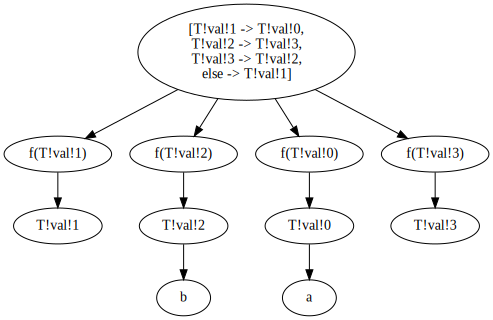

In [ ]:
# eh wahetver
import itertools
import graphviz
dot = graphviz.Digraph()
for decl in m.decls():
    for args in itertools.product(m.get_universe(T), repeat=decl.arity()):
        for a in args:
            dot.edge(str(decl(*args)), str(a))
        dot.edge(str(m[decl]), str(decl(*args)))
dot


# Conjunctive Problems

- $ p \land q \land r ...$ 


# What is a theory?

- A set of statements
- A special black box solver

# Example Theories

- Linear Inequalities
- EUF
- Bounds `x <= 2`
- Difference Logic `x - y <= 2`
- Sequences
- Nonlinear Solvers
- Algebraic datatypes
- Theory of arrays

# Lazy vs Eager

- Eager - Compile everything into SAT
- Lazy
    + Propagation
    + Explanations

# Theory Combination

Nelson Oppen

- Stable, Shiny, Polite theories
- 

- Convex - good propagation. 
- Non-convex - incomplete propagation. Conjunctive problems require arrangement search

Shostak

- Stably infinite = truly fresh constants makes sense. Enables purification / flattening.


# Boolean Satisfiability SAT

- Very easy for formulas `?m |= p /\ q /\ r /\ not w`
- DNF
- Finite models, guess and check. Big loop
- Backtracking search + propagation = DPLL
- CDCL, TWL
- Heuristics

# Theories

- CEGAR
    - Black box bits of your problem to a fit an avaiable solver
    - It gives a solution
    - Is it right? Give new constraint back to solver
    - repeat


# Quantifiers
- Ematching
- MBQI
- EPR


# SMT methods for EGraphs
- Model give arbitrary total model
- Bottom Up Ematching
- Propagation

In [ ]:
from typing import Protocol
class Neq(NamedTuple):
    left: object
    right: object
class Eq(NamedTuple):
    left: object
    right: object
class Theory(Protocol):
    def push(self):
    def pop():
    def assign( , val: bool):
    def propagate() -> list[Eq | Neq]:
    def assert_eq(self, eq: Eq): ... # equal
    def assert_neq(self, neq: Neq): ... # distinct
    def model(self) -> dict[Key, ]: ...
    def freshconst(self) -> Hashable: # makeset
    def explain_val():
    def explain_eq():
    def simplify(): ...


([e!163 == e!164 + e!165, 3 == e!165, 3 == e!167],
 [e!164 == f(e!166), e!166 == f(e!167)],
 [e!164, e!165, e!166, e!167])

In [ ]:
kd.utils.propagate_eqs(smt.BoolVal(True), f(3))
